Please use the Local ./Dockerfile environment 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import umap
import faiss
import openai
import pandas as pd
import numpy as np
import altair as alt
import configparser
from PIL import Image



### Prepare required resources

In [2]:
df_apparel = pd.read_csv('../resources/data/apparel_10to14.tsv.gz', sep='\t', compression='gzip')
cols = ['product_id', 'review_id', 'star_rating', 'product_title', 'review_body']
df_apparel = df_apparel[cols]
df_apparel.head(3)

,product_id,review_id,star_rating,product_title,review_body
0,B00001QHXX,R2HBUQ97RV5JVR,3.0,Richard Nixon Mask,I got this mask for a company party and it fre...
1,B00001QHXX,RHCH92YNAS282,4.0,Richard Nixon Mask,"Nice mask, will have to do some fitting work. ..."
2,B00001QHXX,R1OHYB07D0WE35,5.0,Richard Nixon Mask,"Even though its a bit large, I can't help but ..."


In [3]:
# Load the pre-created FAISS index
faiss_index = faiss.read_index('../resources/binary/apparel_10to14_review_cosine.faissindex')

In [4]:
# Load your API key from an environment variable or secret management service
config = configparser.ConfigParser()
config.read('nes.ini')
openai.api_key = config['OpenAI']['api_key']

### Define helper functions

In [5]:
# Helper function to create the query embedding. Make sure to use the same model as what we used to created the product embedding
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   
   return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'], dtype='float32').reshape(1, -1)

In [6]:
def search_with_original_query(df, faiss_index, query_embedding, num_of_records=100):
    # we need to normalize the question embedding in order to use cosine similarity to search 
    faiss.normalize_L2(query_embedding)

    # distance is the correspnding distance
    # result_idx is the index of the input array, hence the index of the dataframe (if the dataframe index is reset which starts with 0)
    distance, result_idx = faiss_index.search(query_embedding, k=num_of_records)

    # use the return index to create the result dataframe
    df_result = df.iloc[result_idx.squeeze().tolist()]
    # add Distance to the result dataframe
    df_result['distance'] = distance.T

    df_result = df_result.sort_values(by='distance', ascending=True)
    
    return df_result, result_idx

In [7]:
prompt_antonym="""
    You are an English teacher. You need to find every single ADJECTIVE from the sentences delimited by triple backquotes below.
    Then, you transform every adjective into its antonym.
    Finally, give the dictionary meaning for each antonym.
    Below are two examples. You need to comlete the third one. 
    

    Text 1: Kids flip flops for girl, cute, good fit, comfortable and durable, low price
    Output 1: Artless means without guile or deception. Unsuited means not proper or fitting for something. Uncomfortable means causing discomfort.  Fragile means easily broken. Costly means expensive.
    ## 
    Text 2: Long sleeve shirts for men. Wrinkle-free, thick but breathable and slim fit
    Output 2: Short means having little length. Crinkle means to form many short bends or ripples. Thin means measuring little in cross section or diameter. Airtight means impermeable to air or nearly so. Wide means having a greater than usual measure across
    ##
    Text 3:  ```{}```
    Output 3:
"""

In [8]:
def generate_opposite_query(orignal_query='', prompt=''):

    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt.format(orignal_query),
        temperature=0,
        max_tokens=1000,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0
    )

    return response['choices'][0]['text']

### Geneate results

In [9]:
query = "Long thin cotton socks for men, need to be breathable, even feeling cool for summer time."
#query = "Wrinkle free chiffon blouse, sleek style, long sleeve, slim fit, with comfortable inside layer"

In [10]:


# 1) create the embedding for orignal query 
query_embedding = get_embedding(query)
print(f"Original Query === {query}")

# 2) search the FAISS index with orignal query embedding 
df_result_original, result_idx = search_with_original_query(df_apparel, faiss_index, query_embedding, num_of_records=100)

# 3) generate opposite query antonym
opposite_query_antonym = generate_opposite_query(query, prompt_antonym)
print(f"Opposite Query (Antonym)=== {opposite_query_antonym}")

# 4) get the embedding for the opposite query antonym
opposite_query_embedding_antonym = get_embedding(opposite_query_antonym)


Original Query === Long thin cotton socks for men, need to be breathable, even feeling cool for summer time.
Opposite Query (Antonym)=== Short means having little length. Thick means having a greater than usual measure across. Stuffy means not allowing air to circulate freely. Hot means having a high degree of heat or a high temperature.


### UAMP

In [11]:
# make a func to handle the mixed- type data and return the final UMAP embeddings
def umap_embed(df, n_components=2,  n_neighbors= 15, random_state=42):
    #reducer = umap.UMAP(random_state=RAMDOM_STATE, n_components=2, metric='cosine', n_neighbors=10)
    reducer = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors, metric='cosine')
    reducer.fit(df)
    umap_embedding = reducer.transform(df)
   
    return reducer, umap_embedding

In [12]:
def gen_dataframe_for_vis(umap_embedding):

    df = pd.DataFrame(umap_embedding)
    df.index.name='Review'
    df = df.reset_index()
    df.columns = [str(c) for c in df.columns]
    df = df.melt(id_vars=['Review'])
    df['variable'] = df['variable'].astype('int64')

    return df


In [13]:
df_apparel = pd.read_pickle('../resources/data/apparel_10to14_embedding.pkl')

In [14]:
df_result_original.head(3)

,product_id,review_id,star_rating,product_title,review_body,distance
64675,B00M1Y8BDG,R1D0JUBZ3UQYW6,5.0,Hanes Men's Comfortsoft Cotton Printed Lounge ...,"These are nice, light-weight lounge pants. The...",0.863644
26327,B009FG8EYE,RO1TGDIWMUXNW,5.0,Mens 100% Cotton Plain Work/Casual Socks (Pack...,These were amazing super absorbent and h elope...,0.863667
1963,B000G7WC80,R37IPWNRJ74FE3,5.0,Wigwam Men's Cool-Lite Mid Hiker Pro Quarter L...,Love these socks. Orignally got them for summ...,0.863759


In [15]:
df_result_original = df_result_original.merge(df_apparel[['review_id', 'embedding']], left_on='review_id', right_on='review_id', how='inner')

In [16]:
df_search_result_vector = pd.DataFrame(df_result_original['embedding'].values.tolist()).add_prefix('data')

In [17]:
#df_search_result_vector = pd.concat([df_search_result_vector.head(10), df_search_result_vector.tail(10)], axis=0)

In [18]:
reducer, umap_search_result = umap_embed(df_search_result_vector, n_components=10, n_neighbors=10)
df_search_result_plot = gen_dataframe_for_vis(umap_search_result[:20])

In [19]:
umap_search_result.shape

(100, 10)

In [20]:
#np.vstack((umap_search_result[:10], umap_search_result[90:])).shape

In [21]:
df_query_vector  = pd.DataFrame(query_embedding).add_prefix('data')
umap_query = reducer.transform(df_query_vector)
df_query_plot = gen_dataframe_for_vis(umap_query)

In [22]:
df_opposite_query_vector_antonym  = pd.DataFrame(opposite_query_embedding_antonym).add_prefix('data')
umap_opposite_query_antonym  = reducer.transform(df_opposite_query_vector_antonym)
df_opposite_query_plot_antonym  = gen_dataframe_for_vis(umap_opposite_query_antonym)

In [23]:
#df_query_plot.to_csv('../resources/data/temp/df_query_plot.csv', index=False)
#df_opposite_query_plot_antonym.to_csv('../resources/data/temp/df_opposite_query_plot_antonym.csv', index=False)

In [24]:
df_query_plot = pd.read_csv('../resources/data/temp/df_query_plot.csv')
df_opposite_query_plot_antonym = pd.read_csv('../resources/data/temp/df_opposite_query_plot_antonym.csv')

In [25]:
#color_range = ["#FFF33B", "#E93E3A"]

color_range = ["#feebe2", "#7a0177"]

query_chart = alt.Chart(data=df_query_plot).mark_rect().encode(
    x = alt.X('Review:N', title=["Original", "Query"]),
    y = alt.Y('variable:O', title="Component"),
    color=alt.Color('value:Q', title="Value", scale=alt.Scale(range=color_range), legend=None)
)

antonym_chart = alt.Chart(data=df_opposite_query_plot_antonym).mark_rect().encode(
    x = alt.X('Review:N', title=["Opposite", "Query"]),
    y = alt.Y('variable:O', title=""),
    color=alt.Color('value:Q', title="Value", scale=alt.Scale(range=color_range), legend=None)
)

search_result_chart = alt.Chart(data=df_search_result_plot).mark_rect().encode(
    x = alt.X('Review:N', title="Search Result (0-19)"),
    y = alt.Y('variable:O', title=""),
    color=alt.Color('value:Q', title="Value", scale=alt.Scale(range=color_range))
)

title = "Heatmap of the Original Query, Opposite Query and First 20 Search Results"
heatmap_chart = alt.hconcat(query_chart, antonym_chart, search_result_chart, title=alt.Title(text=title, anchor='middle'))

heatmap_chart 


alt.HConcatChart(...)

In [26]:
#heatmap_chart.save('../resources/img/heatmap.png')

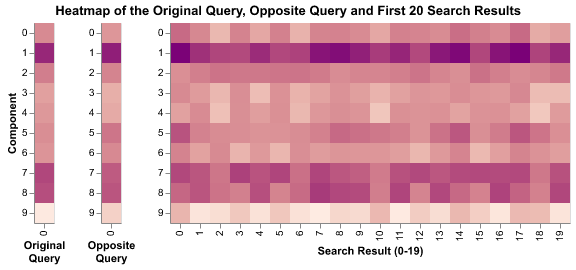

In [27]:
Image.open('../resources/img/heatmap.png')